## Fine Tuning ViT with Udacity Self Driving Car (Behavioral clonning)

#### Import packages with cuda verification

In [1]:
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from torchviz import make_dot
from datetime import datetime
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

Using device: cuda


#### Load base Vision transformer with associated feature extractor

In [2]:
model_id = 'google/vit-base-patch16-224'
device_map = 'balanced_low_0'

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id, device_map=device_map)
vit = ViTModel.from_pretrained(model_id, device_map=device_map)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

/mnt/c/Users/hp/Sinsankio/attention-for-dave2/.venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Data preprocessing and augmentation functions

In [3]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")

    image = image[60:135, :, :]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    return image

def random_brightness(image, brightness_range=(-0.3, 0.3)):
    image_float = image.astype(np.float32)
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])

    image_adjusted = image_float * (1 + brightness_factor)
    image_adjusted = np.clip(image_adjusted, 0, 255)

    return image_adjusted.astype(np.uint8)

def random_shear(image, steering_angle, shear_range=(-0.2, 0.2)):
    rows, cols = image.shape[:2]
    shear_factor = np.random.uniform(shear_range[0], shear_range[1])

    shear_matrix = np.array([
        [1, shear_factor, 0],
        [0, 1, 0]
    ], dtype=np.float32)

    image_sheared = cv2.warpAffine(image, shear_matrix, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    steering_adjustment = -shear_factor * 0.5
    adjusted_steering = np.clip(steering_angle + steering_adjustment, -1.0, 1.0)

    return image_sheared, adjusted_steering

def random_shadow(image, shadow_probability=0.3, intensity_range=(0.2, 0.6)):
    if np.random.random() > shadow_probability:
        return image

    rows, cols = image.shape[:2]

    top_y = cols * np.random.uniform() # random numbers in between 0 to 1 from a uniform distribution
    bottom_y = cols * np.random.uniform()

    shadow_mask = np.zeros((rows, cols), dtype=np.uint8)

    shadow_points = np.array([
        [int(top_y), 0],
        [int(bottom_y), rows],
        [cols, rows],
        [cols, 0]
    ], dtype=np.int32)

    cv2.fillPoly(shadow_mask, [shadow_points], 255)

    shadow_intensity = np.random.uniform(intensity_range[0], intensity_range[1])
    shadowed_image = image.copy().astype(np.float32)

    shadow_region = shadow_mask > 0
    shadowed_image[shadow_region] = shadowed_image[shadow_region] * shadow_intensity

    return np.clip(shadowed_image, 0, 255).astype(np.uint8)

def horizontal_flip(image, steering_angle):
    flipped_image = cv2.flip(image, 1)
    flipped_angle = -steering_angle
    return flipped_image, flipped_angle

def augment_image(image, steering_angle):
    augmented_image = image.copy()
    augmented_angle = steering_angle

    if np.random.random() < 0.8:
        augmented_image = random_brightness(augmented_image)
    
    if np.random.random() < 0.4:
        augmented_image = random_shadow(augmented_image)
    
    if np.random.random() < 0.3:
        augmented_image, augmented_angle = random_shear(augmented_image, augmented_angle)
    
    if np.random.random() < 0.8 and abs(steering_angle) > 0.01:
        augmented_image, augmented_angle = horizontal_flip(augmented_image, augmented_angle)
    
    return augmented_image, augmented_angle

#### Data loading and analysis functions

In [ ]:
def load_csv_samples(base_dir, log_file):
    samples = []
    df = pd.read_csv(log_file, header=0, names=['center', 'left', 'right', 'steering', 'throttle', 'break', 'speed'])
    img_dir = os.path.join(base_dir, 'IMG')

    for _, row in df.iterrows():
        center_img_path = os.path.join(img_dir, row['center'].strip())
        left_img_path = os.path.join(img_dir, row['left'].strip())
        right_img_path = os.path.join(img_dir, row['right'].strip())
        steering = float(row['steering'])
        
        samples.append({
            'center_img_path': center_img_path,
            'left_img_path': left_img_path,
            'right_img_path': right_img_path,
            'steering': steering
        })

    return samples

def analyze_data_distribution(samples, balance_threshold=0.1):
    steering_angles = [sample['steering'] for sample in samples]
    straight_counts = sum(1 for angle in steering_angles if abs(angle) < balance_threshold)
    curve_counts = sum(1 for angle in steering_angles if abs(angle) >= balance_threshold)

    left_counts = sum(1 for angle in steering_angles if angle < -balance_threshold)
    right_counts = sum(1 for angle in steering_angles if angle > balance_threshold)

    total_samples = len(steering_angles)

    print(f"\nData distribution analysis:")
    print(f"  Primary classes:")
    print(f"  - Straight (|angle| < {balance_threshold}): {straight_counts} ({straight_counts/total_samples*100:.1f}%)")
    print(f"  - Curves (|angle| ≥ {balance_threshold}): {curve_counts} ({curve_counts/total_samples*100:.1f}%)")
    print(f"\n  Curve breakdown (for information):")
    print(f"  - Left turns: {left_counts} ({left_counts/curve_counts*100:.1f}% of curves)")
    print(f"  - Right turns: {right_counts} ({right_counts/curve_counts*100:.1f}% of curves)")

    imbalance_ratio = max(straight_counts, curve_counts) / min(straight_counts, curve_counts) if min(straight_counts, curve_counts) > 0 else float('inf')

    print(f"\n  Balance analysis:")
    print(f"  - Straight:Curve ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 2.0:
        print(f"  - High class imbalance detected (ratio > 2:1)")
    elif imbalance_ratio > 1.5:
        print(f"  - Moderate class imbalance detected (ratio > 1.5:1)")
    else:
        print(f"  - Balanced dataset (ratio < 1.5:1)")

def balance_dataset(samples, balance_threshold=0.1):
    straight_samples = []
    curved_samples = []

    for sample in samples:
        angle = sample['steering']
        if abs(angle) < balance_threshold:
            straight_samples.append(sample)
        else:
            curved_samples.append(sample)

    # Balance the dataset by undersampling
    min_samples = min(len(straight_samples), len(curved_samples))
    balanced_samples = (
        straight_samples[:min_samples] +
        curved_samples[:min_samples]
    )

    return balanced_samples

def load_data_samples(data_directories):
    all_samples = []
    for data_dir in data_directories:
        if os.path.exists(data_dir):
            sub_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d.startswith('phase')]
            if sub_dirs:
                for sub_dir in sorted(sub_dirs):
                    phase_dir = os.path.join(data_dir, sub_dir)
                    log_file = os.path.join(phase_dir, 'driving_log.csv')

                    if os.path.exists(log_file):
                        phase_samples = load_csv_samples(phase_dir, log_file)
                        all_samples.extend(phase_samples)
                        print(f"    {sub_dir}: {len(phase_samples)} phase samples")
            else:
                log_file = os.path.join(data_dir, 'driving_log.csv')
                if os.path.exists(log_file):
                    phase_samples = load_csv_samples(data_dir, log_file)
                    all_samples.extend(phase_samples)
                    print(f"    {os.path.basename(data_dir)}: {len(phase_samples)} direct samples")
        
    return all_samples

def analyze_data_distribution(samples, balance_threshold=0.1):
    steering_angles = [sample['steering'] for sample in samples]
    straight_counts = sum(1 for angle in steering_angles if abs(angle) < balance_threshold)
    curve_counts = sum(1 for angle in steering_angles if abs(angle) >= balance_threshold)

    left_counts = sum(1 for angle in steering_angles if angle < -balance_threshold)
    right_counts = sum(1 for angle in steering_angles if angle > balance_threshold)

    total_samples = len(steering_angles)

    print(f"\nData distribution analysis:")
    print(f"  Primary classes:")
    print(f"  - Straight (|angle| < {balance_threshold}): {straight_counts} ({straight_counts/total_samples*100:.1f}%)")
    print(f"  - Curves (|angle| ≥ {balance_threshold}): {curve_counts} ({curve_counts/total_samples*100:.1f}%)")
    print(f"\n  Curve breakdown (for information):")
    print(f"  - Left turns: {left_counts} ({left_counts/curve_counts*100:.1f}% of curves)")
    print(f"  - Right turns: {right_counts} ({right_counts/curve_counts*100:.1f}% of curves)")

    imbalance_ratio = max(straight_counts, curve_counts) / min(straight_counts, curve_counts) if min(straight_counts, curve_counts) > 0 else float('inf')

    print(f"\n  Balance analysis:")
    print(f"  - Straight:Curve ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 2.0:
        print(f"  - High class imbalance detected (ratio > 2:1)")
    elif imbalance_ratio > 1.5:
        print(f"  - Moderate class imbalance detected (ratio > 1.5:1)")
    else:
        print(f"  - Balanced dataset (ratio < 1.5:1)")

#### Data loading

In [5]:
data_directories = [
    f'{os.getcwd()}/dev/data/track-01'
]
val_samples = load_data_samples(data_directories)
len(val_samples)

    phase-01: 16747 phase samples
    phase-02: 24895 phase samples
    phase-03: 18366 phase samples


60008

#### Data analysis

In [6]:
analyze_data_distribution(val_samples)


Data distribution analysis:
  Primary classes:
  - Straight (|angle| < 0.1): 49972 (83.3%)
  - Curves (|angle| ≥ 0.1): 10036 (16.7%)

  Curve breakdown (for information):
  - Left turns: 7461 (74.3% of curves)
  - Right turns: 1676 (16.7% of curves)

  Balance analysis:
  - Straight:Curve ratio: 4.98:1
  - High class imbalance detected (ratio > 2:1)


#### Class balancing with undersampling

In [7]:
balanced_samples = balance_dataset(val_samples)
len(balanced_samples)

20072

In [8]:
balanced_samples[0:5]

[{'center_img_path': '/mnt/c/Users/hp/Sinsankio/attention-for-dave2/dev/data/track-01/phase-01/IMG/center_2025_07_11_18_36_41_622.jpg',
  'left_img_path': '/mnt/c/Users/hp/Sinsankio/attention-for-dave2/dev/data/track-01/phase-01/IMG/left_2025_07_11_18_36_41_622.jpg',
  'right_img_path': '/mnt/c/Users/hp/Sinsankio/attention-for-dave2/dev/data/track-01/phase-01/IMG/right_2025_07_11_18_36_41_622.jpg',
  'steering': 0.0},
 {'center_img_path': '/mnt/c/Users/hp/Sinsankio/attention-for-dave2/dev/data/track-01/phase-01/IMG/center_2025_07_11_18_36_41_716.jpg',
  'left_img_path': '/mnt/c/Users/hp/Sinsankio/attention-for-dave2/dev/data/track-01/phase-01/IMG/left_2025_07_11_18_36_41_716.jpg',
  'right_img_path': '/mnt/c/Users/hp/Sinsankio/attention-for-dave2/dev/data/track-01/phase-01/IMG/right_2025_07_11_18_36_41_716.jpg',
  'steering': 0.0},
 {'center_img_path': '/mnt/c/Users/hp/Sinsankio/attention-for-dave2/dev/data/track-01/phase-01/IMG/center_2025_07_11_18_36_41_788.jpg',
  'left_img_path': '

In [9]:
analyze_data_distribution(balanced_samples)


Data distribution analysis:
  Primary classes:
  - Straight (|angle| < 0.1): 10036 (50.0%)
  - Curves (|angle| ≥ 0.1): 10036 (50.0%)

  Curve breakdown (for information):
  - Left turns: 7461 (74.3% of curves)
  - Right turns: 1676 (16.7% of curves)

  Balance analysis:
  - Straight:Curve ratio: 1.00:1
  - Balanced dataset (ratio < 1.5:1)


#### Visualize data augmentation

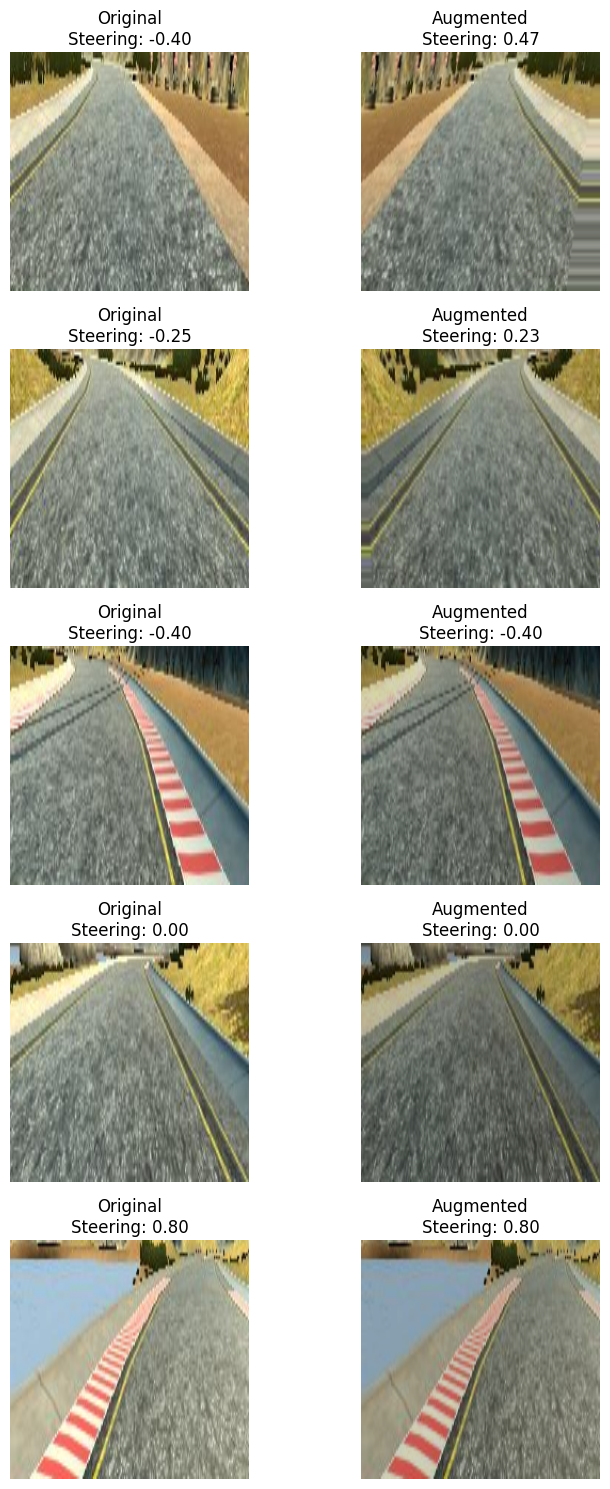

In [ ]:
N = 5
sample_indices = random.sample(range(len(balanced_samples)), N)

fig, axes = plt.subplots(N, 2, figsize=(8, 3 * N))
for i, idx in enumerate(sample_indices):
    sample = balanced_samples[idx]
    orientation = random.choice(['left', 'right', 'center'])
    image_path = sample[f'{orientation}_img_path']
    steering_angle = sample['steering']
   
    orig_image = preprocess_image(image_path)
    aug_image, aug_angle = augment_image(orig_image, steering_angle)
   
    if hasattr(aug_image, 'numpy'):
        aug_image = aug_image.numpy()
   
    # Plot original
    axes[i, 0].imshow(orig_image)
    axes[i, 0].set_title(f"Original\nSteering: {steering_angle:.2f}")
    axes[i, 0].axis('off')
    # Plot augmented
    # If augmented image is (3, 224, 224), transpose to (224, 224, 3)
    if aug_image.shape[0] == 3 and aug_image.shape[-1] != 3:
        aug_image = aug_image.transpose(1, 2, 0)
    axes[i, 1].imshow(aug_image.astype('uint8'))
    axes[i, 1].set_title(f"Augmented\nSteering: {aug_angle:.2f}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

#### Wrapper class with customized model architecture

In [10]:
class ViTForDave2(torch.nn.Module):
    def __init__(self, vit_model):
        super(ViTForDave2, self).__init__()
        self.vit = vit_model
        
        self.fc1 = torch.nn.Linear(self.vit.config.hidden_size, 128)
        self.do1 = torch.nn.Dropout(0.25)
        self.ac1 = torch.nn.ELU()

        self.fc2 = torch.nn.Linear(128, 64)
        self.do2 = torch.nn.Dropout(0.25)
        self.ac2 = torch.nn.ELU()

        self.fc3 = torch.nn.Linear(64, 32)
        self.do3 = torch.nn.Dropout(0.25)
        self.ac3 = torch.nn.ELU()

        self.regressor = torch.nn.Linear(32, 1)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        pooled_output = outputs.pooler_output
        x = self.fc1(pooled_output)
        x = self.do1(x)
        x = self.ac1(x)

        x = self.fc2(x)
        x = self.do2(x)
        x = self.ac2(x)

        x = self.fc3(x)
        x = self.do3(x)
        x = self.ac3(x)

        return self.regressor(x).squeeze(-1)

#### Wrapper class with customized dataset operations

In [11]:
class SteeringDataset(Dataset):
    def __init__(self, image_paths, labels, feature_extractor):
        super().__init__()
        self.image_paths = image_paths
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = preprocess_image(self.image_paths[index])
        angle = self.labels[index]
        if np.random.uniform() <= 0.75:
            image, angle = augment_image(image, angle)
        image = self.feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)   
        angle = torch.tensor(angle, dtype=torch.float32)

        return image, angle

#### Model training

Configs:
- batch size = 32
- validation split = 10% of original dataset
- results: good!

In [ ]:
image_paths = []
steering_angles = []
steering_correction = .2
batch_size = 32

for sample in balanced_samples:
    image_paths.append(sample['center_img_path'])
    image_paths.append(sample['left_img_path'])
    image_paths.append(sample['right_img_path'])
    steering_angles.extend([sample['steering'], sample['steering'] + steering_correction, sample['steering'] - steering_correction])

X_train, X_val, y_train, y_val = train_test_split(image_paths, steering_angles, test_size=.1)
train_dataset = SteeringDataset(X_train, y_train, feature_extractor)
val_dataset = SteeringDataset(X_val, y_val, feature_extractor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [14]:
print('Train samples:', len(train_dataset))
print('Validation samples:', len(val_dataset))

Train samples: 54194
Validation samples: 6022


In [15]:
print('Train batches:', len(train_dataloader))
print('Validation batches:', len(val_dataloader))

Train batches: 1694
Validation batches: 3011


In [ ]:
model = ViTForDave2(vit).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  

In [ ]:
best_train_loss = float('inf')
best_val_loss = float('inf')
best_train_model = None
best_val_model = None
patience = 5
wait = 0
num_epochs = 10
model_save_dir = f'{os.getcwd()}/dev/chkpts'


for epoch in range(num_epochs):
    started_on = datetime.now()
    model.train()
    train_losses = []
    for features, labels in train_dataloader:
        features, labels = features.to(device), labels.to(device)

        preds = model(features)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for features, labels in val_dataloader:
            features, labels = features.to(device), labels.to(device)

            preds = model(features)
            loss = criterion(preds, labels)
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)

    elapsed_time = (datetime.now() - started_on).total_seconds()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time (secs): {elapsed_time:.2f}")

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_train_model = deepcopy(model.state_dict())

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_val_model = deepcopy(model.state_dict())
        wait = 0
    else:
        wait += 1

    if wait >= patience:
        print("Early stopping triggered")
        break

if best_train_model:
    model.load_state_dict(best_train_model)
    torch.save(best_train_model, os.path.join(model_save_dir, "best_train_model_v2.pth"))
    print(f"Best training model saved with loss: {best_train_loss:.4f}")
if best_val_model:
    model.load_state_dict(best_val_model)
    torch.save(best_val_model, os.path.join(model_save_dir, "best_val_model_v2.pth"))
    print(f"Best validation model saved with loss: {best_val_loss:.4f}")


Epoch 1/10 | Train Loss: 0.0621 | Val Loss: 0.0593 | Time (secs): 2045.36
Epoch 2/10 | Train Loss: 0.0496 | Val Loss: 0.0436 | Time (secs): 1966.49
Epoch 3/10 | Train Loss: 0.0446 | Val Loss: 0.0441 | Time (secs): 1946.28
Epoch 4/10 | Train Loss: 0.0400 | Val Loss: 0.0388 | Time (secs): 1957.97
Epoch 5/10 | Train Loss: 0.0364 | Val Loss: 0.0394 | Time (secs): 1956.65
Epoch 6/10 | Train Loss: 0.0323 | Val Loss: 0.0377 | Time (secs): 1957.72
Epoch 7/10 | Train Loss: 0.0296 | Val Loss: 0.0353 | Time (secs): 1970.07
Epoch 8/10 | Train Loss: 0.0275 | Val Loss: 0.0374 | Time (secs): 1955.86
Epoch 9/10 | Train Loss: 0.0254 | Val Loss: 0.0363 | Time (secs): 1952.46
Epoch 10/10 | Train Loss: 0.0234 | Val Loss: 0.0344 | Time (secs): 1953.81
Best training model saved with loss: 0.0234
Best validation model saved with loss: 0.0344


#### Visualize model inference results

In [13]:
data_directories = [
    f'{os.getcwd()}/dev/data/track-01-results'
]
val_samples = load_data_samples(data_directories, validation=True)
len(val_samples)

    phase-01: 13647 phase samples


13647

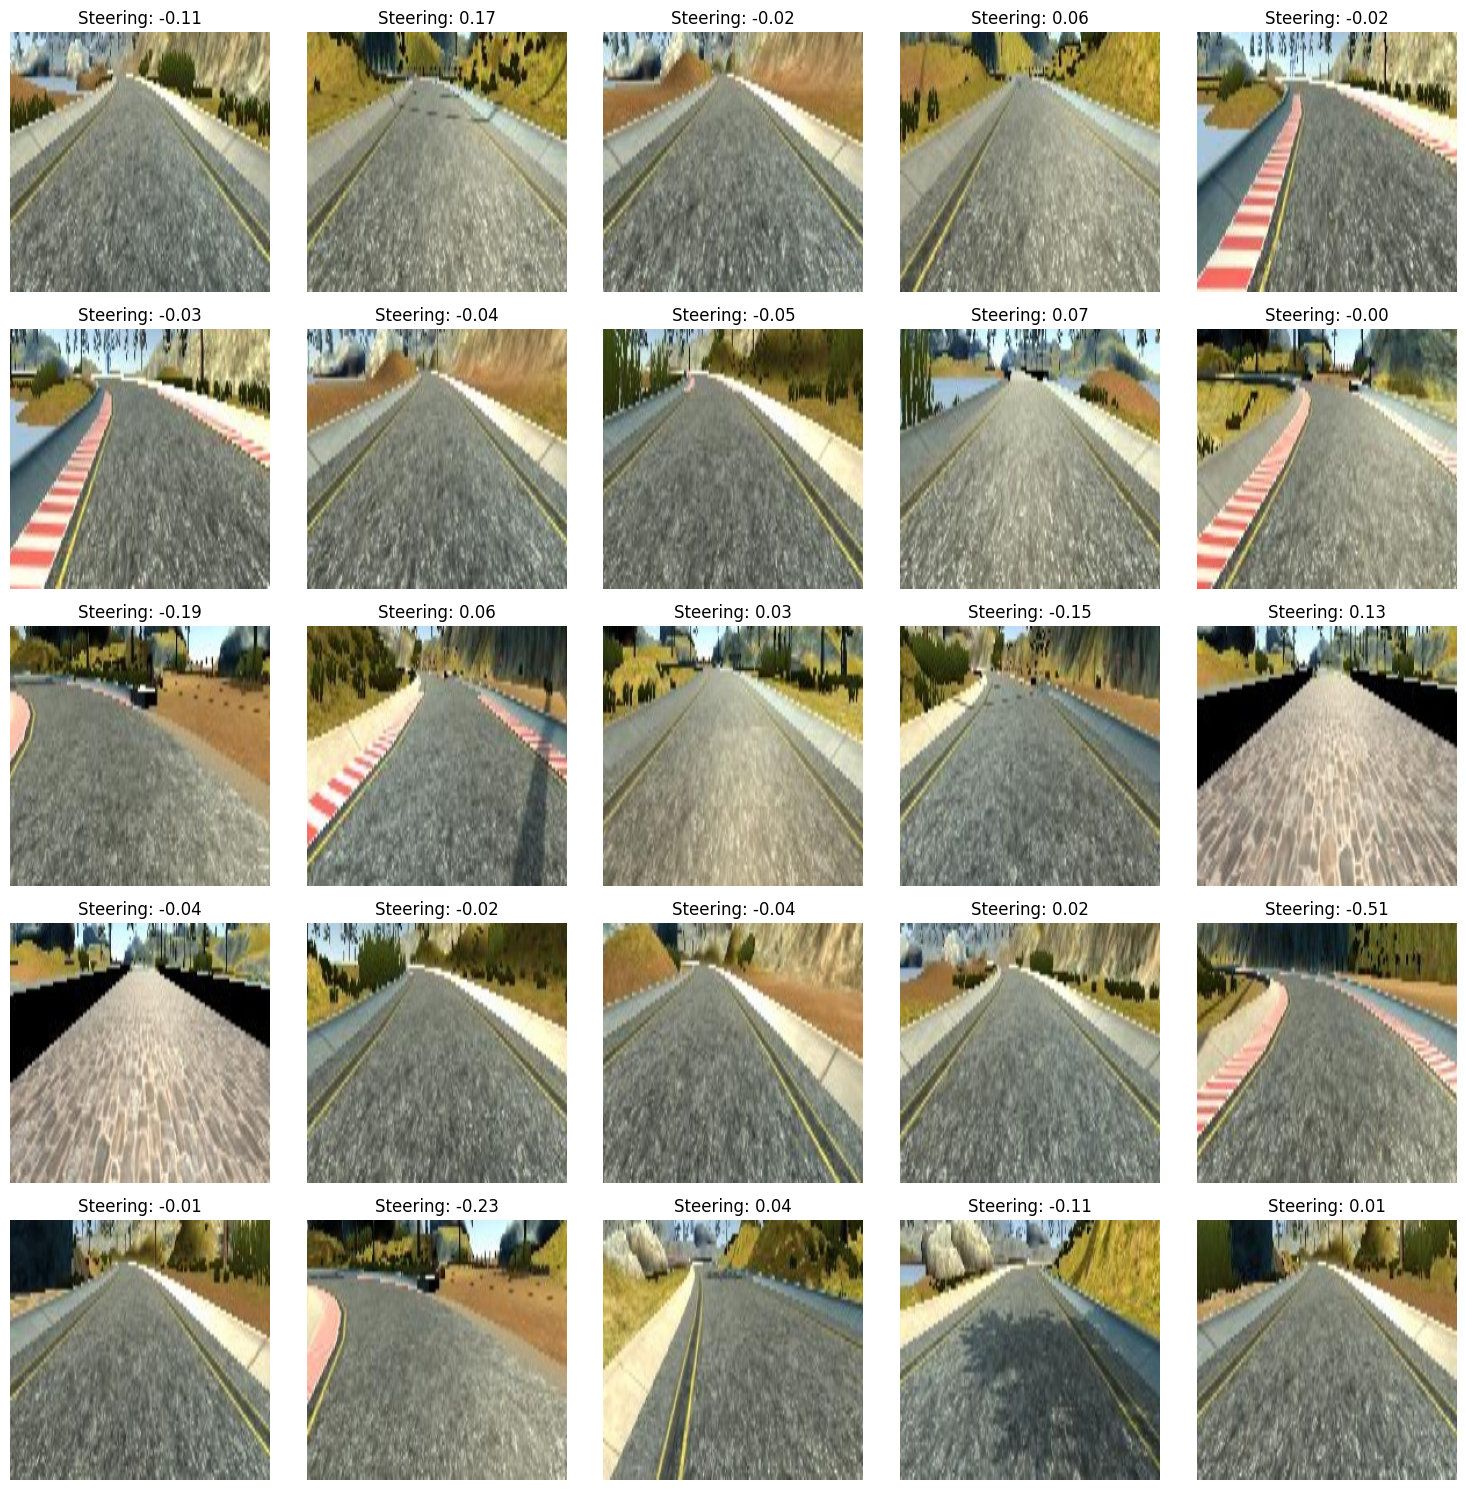

In [25]:
N = 5
sample_indices = random.sample(range(len(val_samples)), N * N)

fig, axes = plt.subplots(N, N, figsize=(15, 15))
for i in range(N):
    for j in range(N):
        idx = sample_indices[i * N + j]
        sample = val_samples[idx]
        image_path = sample['img_path']
        steering_angle = sample['steering']

        orig_image = cv2.imread(image_path)
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

        axes[i, j].imshow(orig_image)
        axes[i, j].set_title(f"Steering: {steering_angle:.2f}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()